In [ ]:
import tensorflow.compat.v2 as tf

from keras import backend
from keras.applications import imagenet_utils
from keras.engine import training
from keras.layers import VersionAwareLayers
from keras.utils import data_utils
from keras.utils import layer_utils
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import numpy as np
import os
import PIL
import tensorflow as tf
import datetime
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import initializers

In [ ]:
# Checkout the labels of our data
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/train.csv")
df = df[:50000]

In [ ]:
df

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,CheXpert-v1.0-small/train/patient12158/study9/...,Male,63,Frontal,AP,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN
49996,CheXpert-v1.0-small/train/patient12158/study1/...,Male,62,Frontal,AP,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
49997,CheXpert-v1.0-small/train/patient12158/study6/...,Male,63,Frontal,AP,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
49998,CheXpert-v1.0-small/train/patient12158/study2/...,Male,62,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,NaN,-1.0,NaN,0.0,NaN,NaN,NaN,1.0


In [ ]:
# Define the three classes you want to use
class_names = ["No Finding", "Pleural Effusion"]
#class_names = ["Lung Opacity", "Support Devices"]

# Filter the dataframe to only include samples from these classes
df_filtered = df[df[class_names].notna().any(axis=1)][class_names + ["Path"]]

# Shuffle the dataframe and reset the index
df_filtered = df_filtered.sample(frac=1).reset_index(drop=True)

In [ ]:
df_filtered

,No Finding,Pleural Effusion,Path
0,NaN,1.0,CheXpert-v1.0-small/train/patient05242/study4/...
1,NaN,1.0,CheXpert-v1.0-small/train/patient03179/study2/...
2,NaN,1.0,CheXpert-v1.0-small/train/patient06358/study5/...
3,NaN,1.0,CheXpert-v1.0-small/train/patient00025/study2/...
4,NaN,0.0,CheXpert-v1.0-small/train/patient10514/study1/...
...,...,...,...
32757,NaN,-1.0,CheXpert-v1.0-small/train/patient03143/study3/...
32758,NaN,-1.0,CheXpert-v1.0-small/train/patient11514/study6/...
32759,NaN,1.0,CheXpert-v1.0-small/train/patient07858/study2/...
32760,NaN,1.0,CheXpert-v1.0-small/train/patient07961/study4/...


In [ ]:
labels = df.iloc[:, 5:].values

labels_dataset = list(df.columns[5:])
labels_dataset

for i in class_names:
  df_filtered[i] = df_filtered[i].apply(lambda x : 1 if x == 1 else 0)

In [ ]:
df_filtered

,No Finding,Pleural Effusion,Path
0,0,1,CheXpert-v1.0-small/train/patient05242/study4/...
1,0,1,CheXpert-v1.0-small/train/patient03179/study2/...
2,0,1,CheXpert-v1.0-small/train/patient06358/study5/...
3,0,1,CheXpert-v1.0-small/train/patient00025/study2/...
4,0,0,CheXpert-v1.0-small/train/patient10514/study1/...
...,...,...,...
32757,0,0,CheXpert-v1.0-small/train/patient03143/study3/...
32758,0,0,CheXpert-v1.0-small/train/patient11514/study6/...
32759,0,1,CheXpert-v1.0-small/train/patient07858/study2/...
32760,0,1,CheXpert-v1.0-small/train/patient07961/study4/...


In [ ]:
df_filtered = df_filtered.loc[(df_filtered['No Finding'] == 1) | (df_filtered['Pleural Effusion'] == 1)]
df_filtered = df_filtered.sample(frac=1).reset_index(drop=True)


In [ ]:
df_filtered

,No Finding,Pleural Effusion,Path
0,1,0,CheXpert-v1.0-small/train/patient01734/study1/...
1,1,0,CheXpert-v1.0-small/train/patient02005/study1/...
2,0,1,CheXpert-v1.0-small/train/patient06655/study14...
3,1,0,CheXpert-v1.0-small/train/patient07764/study9/...
4,0,1,CheXpert-v1.0-small/train/patient10181/study1/...
...,...,...,...
23693,1,0,CheXpert-v1.0-small/train/patient03303/study1/...
23694,0,1,CheXpert-v1.0-small/train/patient02533/study26...
23695,0,1,CheXpert-v1.0-small/train/patient05804/study14...
23696,0,1,CheXpert-v1.0-small/train/patient03442/study1/...


In [ ]:
#df_filtered, len(df_filtered)
df_filtered['No Finding']

0        1
1        1
2        0
3        1
4        0
        ..
23693    1
23694    0
23695    0
23696    0
23697    0
Name: No Finding, Length: 23698, dtype: int64

In [ ]:
no_finding_counts = df_filtered['Pleural Effusion'].value_counts()
no_finding_counts

1    17917
0     5781
Name: Pleural Effusion, dtype: int64

In [ ]:
pleural_effusion_counts = df_filtered['No Finding'].value_counts()
pleural_effusion_counts

0    17917
1     5781
Name: No Finding, dtype: int64

In [ ]:
df_sampled = df_filtered.groupby(['No Finding', 'Pleural Effusion']).apply(lambda x: x.sample(n=1200, random_state=42)).reset_index(drop=True)

In [ ]:
df_sampled

,No Finding,Pleural Effusion,Path
0,0,1,CheXpert-v1.0-small/train/patient12127/study4/...
1,0,1,CheXpert-v1.0-small/train/patient11490/study8/...
2,0,1,CheXpert-v1.0-small/train/patient05864/study1/...
3,0,1,CheXpert-v1.0-small/train/patient08549/study29...
4,0,1,CheXpert-v1.0-small/train/patient05174/study2/...
...,...,...,...
2395,1,0,CheXpert-v1.0-small/train/patient05744/study1/...
2396,1,0,CheXpert-v1.0-small/train/patient09305/study1/...
2397,1,0,CheXpert-v1.0-small/train/patient11513/study1/...
2398,1,0,CheXpert-v1.0-small/train/patient06527/study1/...


In [ ]:
no_finding_counts = df_sampled['No Finding'].value_counts()
no_finding_counts

0    1200
1    1200
Name: No Finding, dtype: int64

In [ ]:
pleural_effusion_counts = df_sampled['Pleural Effusion'].value_counts()
pleural_effusion_counts

1    1200
0    1200
Name: Pleural Effusion, dtype: int64

In [ ]:
df_filtered

,No Finding,Pleural Effusion,Path
0,1,0,CheXpert-v1.0-small/train/patient01734/study1/...
1,1,0,CheXpert-v1.0-small/train/patient02005/study1/...
2,0,1,CheXpert-v1.0-small/train/patient06655/study14...
3,1,0,CheXpert-v1.0-small/train/patient07764/study9/...
4,0,1,CheXpert-v1.0-small/train/patient10181/study1/...
...,...,...,...
23693,1,0,CheXpert-v1.0-small/train/patient03303/study1/...
23694,0,1,CheXpert-v1.0-small/train/patient02533/study26...
23695,0,1,CheXpert-v1.0-small/train/patient05804/study14...
23696,0,1,CheXpert-v1.0-small/train/patient03442/study1/...


In [ ]:
# Create pathnames from image Path
#filenames = []
filenames = ["drive/MyDrive/Deep-Learning/" + fname for fname in df_sampled["Path"]]

# Check the first 10
filenames[:10]

['drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/train/patient12127/study4/view1_frontal.jpg',
 'drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/train/patient11490/study8/view1_frontal.jpg',
 'drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/train/patient05864/study1/view1_frontal.jpg',
 'drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/train/patient08549/study29/view2_frontal.jpg',
 'drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/train/patient05174/study2/view1_frontal.jpg',
 'drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/train/patient10895/study4/view1_frontal.jpg',
 'drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/train/patient07703/study2/view2_lateral.jpg',
 'drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/train/patient09461/study6/view1_frontal.jpg',
 'drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/train/patient07931/study4/view2_lateral.jpg',
 'drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/train/patient04864/study2/view1_frontal.jpg']

In [ ]:
array_images_classification =[]

for j in range(len(df_sampled["Path"])):
  path = df_sampled["Path"][j]
  classifications = []
  for i in class_names:
    classifications.append(df_sampled[i][j])
  array_images_classification.append(classifications)

In [ ]:
#array_images_classification

In [ ]:

array_images_classification[:2]
# one-hot encode the labels
labels = np.array(array_images_classification)

In [ ]:
len(labels), len(filenames)

(2400, 2400)

## Outro teste

In [ ]:
labels_formatted = []

for i in labels:
  if i[0] == 1:
    labels_formatted.append(class_names[0])
  elif i[1] == 1:
    labels_formatted.append(class_names[1])
  else:
    labels_formatted.append(class_names[0])
    

In [ ]:
labels_formatted[:10]

['Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion']

In [ ]:
labels_formatted = np.array(labels_formatted, dtype=object)
len(labels_formatted)

2400

In [ ]:
class_names_formatted = np.array(class_names, dtype=object)
class_names_formatted

array(['No Finding', 'Pleural Effusion'], dtype=object)

In [ ]:
len(labels_formatted), len(filenames), len(class_names_formatted)

(2400, 2400, 2)

In [ ]:
# Turn a single label into an array of booleans
print(labels_formatted[0])
labels_formatted[0] == class_names_formatted

Pleural Effusion


array([False,  True])

In [ ]:
# Turn every label into a boolean array
boolean_labels = [test == class_names_formatted for test in labels_formatted]
boolean_labels[:4]

[array([False,  True]),
 array([False,  True]),
 array([False,  True]),
 array([False,  True])]

In [ ]:
# Example: Turning boolean array into intergers
print(labels_formatted[0]) # original label
print(np.where(class_names_formatted == labels_formatted[0])) # index where label occurs
print(boolean_labels[0]) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample label occurs

Pleural Effusion
(array([1]),)
[False  True]
[0 1]


In [ ]:
# Setup X & y variables
X = filenames
y = boolean_labels

In [ ]:
len(filenames), len(boolean_labels)

(2400, 2400)

In [ ]:
from sklearn.model_selection import train_test_split

# Split them into training and validation
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size=0.2,
                                                  random_state=42)

len(X_train), len(y_train), len(X_val), len(y_val)

(1920, 1920, 480, 480)

In [ ]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[10])
image.shape

(320, 320)

In [ ]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path: str, img_size:int=IMG_SIZE) -> tf.constant:
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channels values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  print(type(image))

  return image



In [ ]:
# Simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  image = process_image(image_path)
  return image, label

In [ ]:
#(process_image(X[10]), tf.constant(y[10]))

In [ ]:
BATCH_SIZE = 16
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels

    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)

  return data_batch

In [ ]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
<class 'tensorflow.python.framework.ops.Tensor'>
Creating validation data batches...
<class 'tensorflow.python.framework.ops.Tensor'>


In [ ]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 2), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 2), dtype=tf.bool, name=None)))

In [ ]:
import matplotlib.pyplot as plt


def show_images(images, labels):
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 3 (for displaying 3 images)
  for i in range(3):
    # Create subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(class_names_formatted[labels[i].argmax()])
    # Turn the grid lines off
    plt.axis("off")

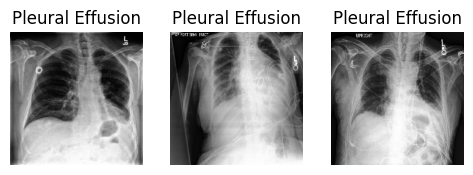

In [ ]:
train_images, train_labels = next(train_data.as_numpy_iterator())
# Now let's visualize the data in a training batch
show_images(train_images, train_labels)

In [ ]:
# Create a function which builds a Keras model
from tensorflow.keras.models import Model
def create_model():

  # Load the VGG16 model with pre-trained ImageNet weights
  base_model = VGG16(include_top=False, input_shape=(224, 224, 3))

  # Add a custom classification head
  x = base_model.output
  x = Flatten()(x)
  x = Dense(128, activation='relu')(x)
  x = Dense(64, activation='relu')(x)
  predictions = Dense(2, activation='softmax')(x)

  # Create the final model
  model = Model(inputs=base_model.input, outputs=predictions)

  # Freeze the pre-trained layers
  #for layer in base_model.layers:
      #layer.trainable = False

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
      metrics=["accuracy"]
  )

  # Build the model
  #model.build(INPUT_SHAPE)

  return model

In [ ]:
#model = create_model()
#model.summary()

In [ ]:
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()
  # Create early stopping callback
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                    patience=3)

  # Fit the model to the data
  model.fit(x=train_data,
            epochs=10,
            validation_data=val_data,
            callbacks=[early_stopping])
  
  return model

In [ ]:
# Fit the model to the data
model = train_model()

Epoch 1/10
120/120 [==============================] - 989s 8s/step - loss: 0.5837 - accuracy: 0.6911 - val_loss: 0.4223 - val_accuracy: 0.8083
Epoch 2/10
120/120 [==============================] - 28s 236ms/step - loss: 0.4498 - accuracy: 0.8172 - val_loss: 0.4457 - val_accuracy: 0.7896
Epoch 3/10
120/120 [==============================] - 29s 240ms/step - loss: 0.4155 - accuracy: 0.8266 - val_loss: 0.3602 - val_accuracy: 0.8354
Epoch 4/10
120/120 [==============================] - 29s 242ms/step - loss: 0.3816 - accuracy: 0.8375 - val_loss: 0.4034 - val_accuracy: 0.8375
Epoch 5/10
120/120 [==============================] - 29s 243ms/step - loss: 0.3440 - accuracy: 0.8687 - val_loss: 0.3409 - val_accuracy: 0.8708
Epoch 6/10
120/120 [==============================] - 29s 244ms/step - loss: 0.3294 - accuracy: 0.8729 - val_loss: 0.3470 - val_accuracy: 0.8667
Epoch 7/10
120/120 [==============================] - 29s 244ms/step - loss: 0.3058 - accuracy: 0.8802 - val_loss: 0.3156 - val_accu

In [ ]:
#print(model.history.history["accuracy"])

In [ ]:
def plot_training_loss(model):
  # access the history object and plot the loss
  plt.plot(model.history.history['loss'])
  plt.plot(model.history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

In [ ]:
def plot_training_accuracy(model):
  plt.plot(model.history.history['accuracy'])
  plt.plot(model.history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

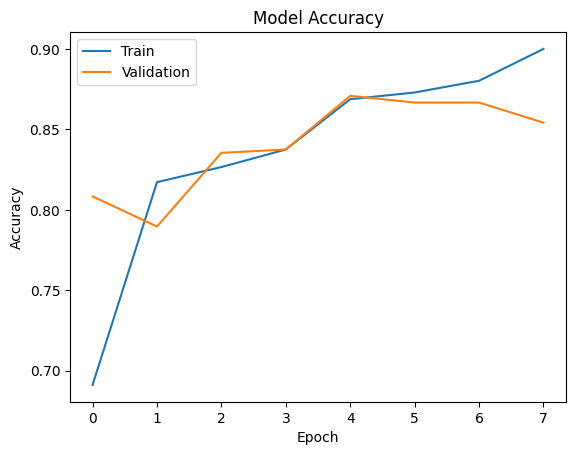

In [ ]:
plot_training_accuracy(model)

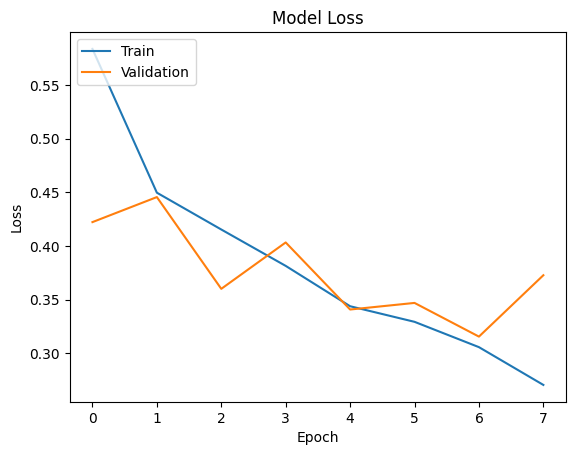

In [ ]:
plot_training_loss(model)

In [ ]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1)
predictions

30/30 [==============================] - 2s 64ms/step


array([[0.97173   , 0.02827004],
       [0.6843435 , 0.31565648],
       [0.14367154, 0.8563284 ],
       [0.35060346, 0.64939654],
       [0.6416268 , 0.35837322],
       [0.19138227, 0.8086177 ],
       [0.98972297, 0.01027696],
       [0.9919927 , 0.00800721],
       [0.94901145, 0.05098856],
       [0.08287607, 0.9171239 ],
       [0.7168317 , 0.28316838],
       [0.45869556, 0.54130447],
       [0.15424204, 0.84575796],
       [0.94538677, 0.05461321],
       [0.9856213 , 0.01437872],
       [0.9622352 , 0.03776472],
       [0.22407743, 0.7759226 ],
       [0.92740905, 0.07259092],
       [0.9218981 , 0.07810193],
       [0.994726  , 0.005274  ],
       [0.13339688, 0.8666031 ],
       [0.9247511 , 0.07524885],
       [0.47816154, 0.5218385 ],
       [0.9896706 , 0.0103295 ],
       [0.9688325 , 0.03116755],
       [0.23583488, 0.7641651 ],
       [0.9294312 , 0.07056885],
       [0.9833972 , 0.01660288],
       [0.9056889 , 0.09431115],
       [0.9368733 , 0.06312668],
       [0.

In [ ]:
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return class_names[np.argmax(prediction_probabilities)]

In [ ]:
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separete arrays of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(class_names[np.argmax(label)])

  return images, labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]

(array([[[0.03232668, 0.03232668, 0.03232668],
         [0.02583158, 0.02583158, 0.02583158],
         [0.0237964 , 0.0237964 , 0.0237964 ],
         ...,
         [0.7806986 , 0.7806986 , 0.7806986 ],
         [0.7445729 , 0.7445729 , 0.7445729 ],
         [0.828427  , 0.828427  , 0.828427  ]],
 
        [[0.02616422, 0.02616422, 0.02616422],
         [0.01966912, 0.01966912, 0.01966912],
         [0.01708684, 0.01708684, 0.01708684],
         ...,
         [0.29855135, 0.29855135, 0.29855135],
         [0.3928309 , 0.3928309 , 0.3928309 ],
         [0.44483548, 0.44483548, 0.44483548]],
 
        [[0.02616422, 0.02616422, 0.02616422],
         [0.02325368, 0.02325368, 0.02325368],
         [0.0194284 , 0.0194284 , 0.0194284 ],
         ...,
         [0.06219362, 0.06219362, 0.06219362],
         [0.07554709, 0.07554709, 0.07554709],
         [0.08969276, 0.08969276, 0.08969276]],
 
        ...,
 
        [[0.8349757 , 0.8349757 , 0.8349757 ],
         [0.84943336, 0.84943336, 0.84943

In [ ]:
images_ = []
labels_ = []

# Loop through unbatched data
for image, label in val_data.unbatch().as_numpy_iterator():
  images_.append(image)
  labels_.append(label)

In [ ]:
get_pred_label(labels_[0])

'No Finding'

In [ ]:
get_pred_label(predictions[0])

'No Finding'

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction is right or wrong

  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("Result: {} {:2.0f}% Expected: {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)

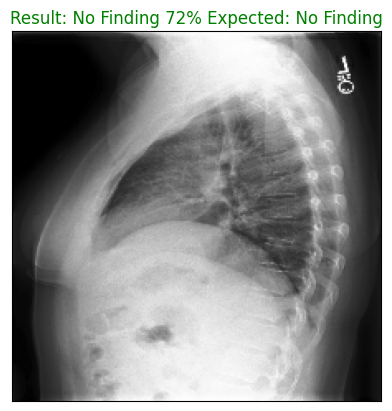

In [ ]:
plot_pred(prediction_probabilities=predictions,
          labels=val_labels,
          images=val_images,n=10)

In [ ]:
# Create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("drive/MyDrive/Deep-Learning/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [ ]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f'Loading saved model from: {model_path}')
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer": hub.KerasLayer})
  return model

In [ ]:
# Save our model trained on 1000 images
save_model(model, suffix="chesxpert-vgg16-balanced-1200-final-Adam")

Saving model to: drive/MyDrive/Deep-Learning/models/20230522-13351684762509-chesxpert-vgg16-balanced-1200-final-Adam.h5...


'drive/MyDrive/Deep-Learning/models/20230522-13351684762509-chesxpert-vgg16-balanced-1200-final-Adam.h5'

In [ ]:
# Load a trained model
loaded_images_model = load_model("drive/MyDrive/Deep-Learning/models/20230522-13351684762509-chesxpert-vgg16-balanced-1200-final-Adam.h5")

Loading saved model from: drive/MyDrive/Deep-Learning/models/20230522-13351684762509-chesxpert-vgg16-balanced-1200-final-Adam.h5


In [ ]:
# Evaluate the pre-saved model
model.evaluate(val_data)

30/30 [==============================] - 2s 67ms/step - loss: 0.3728 - accuracy: 0.8542


[0.37284237146377563, 0.8541666865348816]

In [ ]:
# Evaluate the laoded model
loaded_images_model.evaluate(val_data)

30/30 [==============================] - 2s 69ms/step - loss: 0.3728 - accuracy: 0.8542


[0.37284237146377563, 0.8541666865348816]

In [ ]:
df_test = pd.read_csv("/content/drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/valid.csv")

In [ ]:
# Define the three classes you want to use
class_names = ["No Finding", "Pleural Effusion"]
#class_names = ["Lung Opacity", "Support Devices"]

# Filter the dataframe to only include samples from these classes
df_test_filtered = df_test[df_test[class_names].notna().any(axis=1)][class_names + ["Path"]]

# Shuffle the dataframe and reset the index
df_test_filtered = df_test_filtered.sample(frac=1).reset_index(drop=True)

In [ ]:
df_test_filtered = df_test_filtered.loc[(df_test_filtered['No Finding'] == 1) | (df_test_filtered['Pleural Effusion'] == 1)]
df_test_filtered = df_test_filtered.sample(frac=1).reset_index(drop=True)


In [ ]:
df_test_filtered

,No Finding,Pleural Effusion,Path
0,1.0,0.0,CheXpert-v1.0-small/valid/patient64558/study1/...
1,1.0,0.0,CheXpert-v1.0-small/valid/patient64562/study1/...
2,1.0,0.0,CheXpert-v1.0-small/valid/patient64588/study1/...
3,1.0,0.0,CheXpert-v1.0-small/valid/patient64595/study1/...
4,1.0,0.0,CheXpert-v1.0-small/valid/patient64696/study1/...
...,...,...,...
100,1.0,0.0,CheXpert-v1.0-small/valid/patient64618/study1/...
101,0.0,1.0,CheXpert-v1.0-small/valid/patient64674/study1/...
102,0.0,1.0,CheXpert-v1.0-small/valid/patient64580/study1/...
103,0.0,1.0,CheXpert-v1.0-small/valid/patient64704/study1/...


In [ ]:
df_sampled_test = df_test_filtered.groupby(['No Finding', 'Pleural Effusion']).apply(lambda x: x.sample(n=35, random_state=42)).reset_index(drop=True)

In [ ]:
df_sampled_test

,No Finding,Pleural Effusion,Path
0,0.0,1.0,CheXpert-v1.0-small/valid/patient64644/study1/...
1,0.0,1.0,CheXpert-v1.0-small/valid/patient64657/study1/...
2,0.0,1.0,CheXpert-v1.0-small/valid/patient64725/study1/...
3,0.0,1.0,CheXpert-v1.0-small/valid/patient64646/study1/...
4,0.0,1.0,CheXpert-v1.0-small/valid/patient64640/study1/...
...,...,...,...
65,1.0,0.0,CheXpert-v1.0-small/valid/patient64615/study1/...
66,1.0,0.0,CheXpert-v1.0-small/valid/patient64575/study1/...
67,1.0,0.0,CheXpert-v1.0-small/valid/patient64588/study1/...
68,1.0,0.0,CheXpert-v1.0-small/valid/patient64558/study1/...


In [ ]:
# Create pathnames from image path
#filenames = []
test_filenames = ["drive/MyDrive/Deep-Learning/" + fname for fname in df_sampled_test["Path"]]

# Check the first 10
test_filenames[:10]

['drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/valid/patient64644/study1/view1_frontal.jpg',
 'drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/valid/patient64657/study1/view1_frontal.jpg',
 'drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/valid/patient64725/study1/view1_frontal.jpg',
 'drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/valid/patient64646/study1/view1_frontal.jpg',
 'drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/valid/patient64640/study1/view2_lateral.jpg',
 'drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/valid/patient64691/study1/view1_frontal.jpg',
 'drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/valid/patient64577/study1/view1_frontal.jpg',
 'drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/valid/patient64718/study1/view1_frontal.jpg',
 'drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/valid/patient64580/study1/view1_frontal.jpg',
 'drive/MyDrive/Deep-Learning/CheXpert-v1.0-small/valid/patient64636/study1/view1_frontal.jpg']

In [ ]:

array_images_test_classification =[]

for j in range(len(df_sampled_test["Path"])):
  path = df_sampled_test["Path"][j]
  classifications = []
  for i in class_names:
    classifications.append(df_sampled_test[i][j])
  array_images_test_classification.append(classifications)

In [ ]:

array_images_classification[:2]
# one-hot encode the labels
labels_test = np.array(array_images_test_classification)

In [ ]:
len(labels_test), len(test_filenames)

(70, 70)

In [ ]:
labels_test_formatted = []

for i in labels_test:
  if i[0] == 1:
    labels_test_formatted.append(class_names[0])
  elif i[1] == 1:
    labels_test_formatted.append(class_names[1])
  else:
    labels_test_formatted.append(class_names[0])
    

In [ ]:
labels_test_formatted[:5]

['Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion']

In [ ]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...
<class 'tensorflow.python.framework.ops.Tensor'>


In [ ]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_images_model.predict(test_data,
                                             verbose=1)

5/5 [==============================] - 41s 8s/step


In [ ]:
# Get custom image predictions labels
custom_pred_labels = [get_pred_label(test_predictions[i]) for i in range(len(test_predictions))]
custom_pred_labels

['Pleural Effusion',
 'Pleural Effusion',
 'No Finding',
 'No Finding',
 'No Finding',
 'No Finding',
 'No Finding',
 'No Finding',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'No Finding',
 'Pleural Effusion',
 'Pleural Effusion',
 'No Finding',
 'Pleural Effusion',
 'No Finding',
 'No Finding',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'No Finding',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'Pleural Effusion',
 'No Finding',
 'No Finding',
 'Pleural Effusion',
 'No Finding',
 'No Finding',
 'No Finding',
 'Pleural Effusion',
 'No Finding',
 'No Finding',
 'No Finding',
 'No Finding',
 'No Finding',
 'No Finding',
 'No Finding',
 'No Finding',
 'No Finding',
 'No Finding',
 'No Finding',
 'No Finding',
 'No Finding',
 'Pleural Effusion',
 'No Finding',
 'No Finding',
 'No Finding',
 'No Finding',
 'No Finding',
 'No Fi

In [ ]:
# Get custom images (our unbatchify() function won't work since there aren't labels... maybe we could fix this later)
custom_images = []
# Loop through unbatched data
for image in test_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

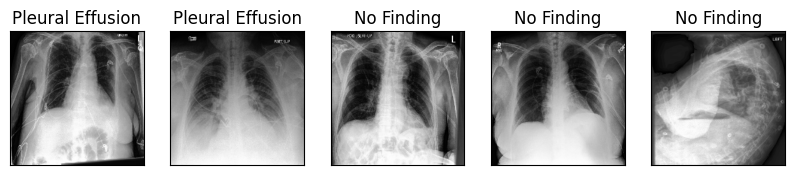

In [ ]:
# Check custom image predictions 
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  if i+1 == 6:
    break
  plt.subplot(1, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)

In [ ]:
len(custom_pred_labels), len(labels_test_formatted)

(70, 70)

In [ ]:
from sklearn.metrics import accuracy_score

true_labels = labels_test_formatted
predicted_labels = custom_pred_labels

accuracy = accuracy_score(labels_test_formatted, custom_pred_labels)

print("Accuracy: {:.2f}%".format(accuracy * 100))


Accuracy: 77.14%


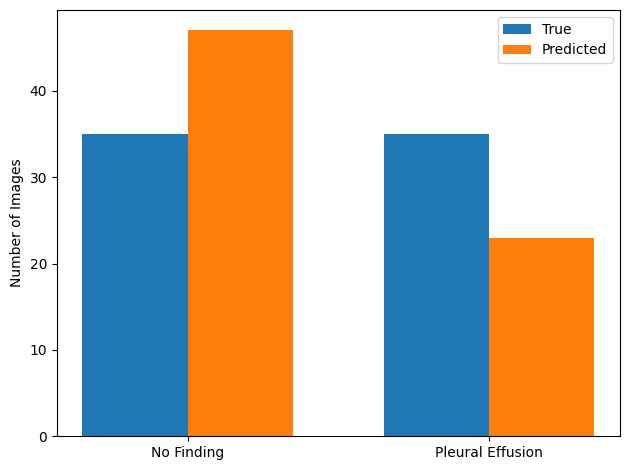

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Count the number of true "No Finding" and "Pleural Effusion" labels
true_counts = {"No Finding": 0, "Pleural Effusion": 0}
for label in true_labels:
    true_counts[label] += 1

# Count the number of predicted "No Finding" and "Pleural Effusion" labels
pred_counts = {"No Finding": 0, "Pleural Effusion": 0}
for i, label in enumerate(predicted_labels):
    if label == "No Finding":
        pred_counts["No Finding"] += 1
    else:
        pred_counts["Pleural Effusion"] += 1

# Create a bar chart
labels = ["No Finding", "Pleural Effusion"]
true_values = [true_counts["No Finding"], true_counts["Pleural Effusion"]]
pred_values = [pred_counts["No Finding"], pred_counts["Pleural Effusion"]]
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, true_values, width, label='True')
rects2 = ax.bar(x + width/2, pred_values, width, label='Predicted')
ax.set_ylabel('Number of Images')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
plt.show()


### 2 parte do trabalho

# Batch Normalization

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization
from tensorflow.keras.models import Model

def create_model_with_BN(input_shape=(224, 224, 3), num_classes=2):
    # Define input tensor shape
    inputs = Input(shape=input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', activation="relu")(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same', activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), padding='same', activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), padding='same', activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), padding='same', activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), padding='same', activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), padding='same', activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    # Block 5
    x = Conv2D(512, (3, 3), padding='same', activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), padding='same', activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), padding='same', activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    # Classification block
    x = Flatten()(x)
    x = Dense(64, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation="relu")(x)
    x = BatchNormalization()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Define model
    model = Model(inputs, outputs)

    model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
      metrics=["accuracy"]
    )
    
    return model


In [ ]:
def train_model_with_BN():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model_with_BN()
  # Create early stopping callback
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                    patience=3)

  # Fit the model to the data
  model.fit(x=train_data,
            epochs=15,
            validation_data=val_data)
  
  return model

In [ ]:
# Fit the model to the data
model_with_BN = train_model_with_BN()

Epoch 1/15
100/100 [==============================] - 625s 6s/step - loss: 0.5746 - accuracy: 0.7525 - val_loss: 1.1043 - val_accuracy: 0.5025
Epoch 2/15
100/100 [==============================] - 27s 268ms/step - loss: 0.3814 - accuracy: 0.8350 - val_loss: 0.9679 - val_accuracy: 0.5025
Epoch 3/15
100/100 [==============================] - 26s 262ms/step - loss: 0.2794 - accuracy: 0.8925 - val_loss: 0.7479 - val_accuracy: 0.5050
Epoch 4/15
100/100 [==============================] - 27s 267ms/step - loss: 0.2161 - accuracy: 0.9194 - val_loss: 0.5575 - val_accuracy: 0.7175
Epoch 5/15
100/100 [==============================] - 26s 259ms/step - loss: 0.2542 - accuracy: 0.8994 - val_loss: 0.6839 - val_accuracy: 0.7525
Epoch 6/15
100/100 [==============================] - 26s 262ms/step - loss: 0.3438 - accuracy: 0.8581 - val_loss: 0.5109 - val_accuracy: 0.7675
Epoch 7/15
100/100 [==============================] - 26s 259ms/step - loss: 0.2109 - accuracy: 0.9212 - val_loss: 0.4672 - val_accu

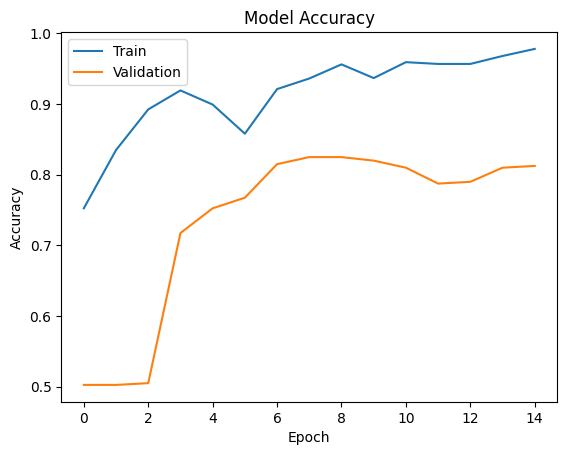

In [ ]:
plot_training_accuracy(model_with_BN)

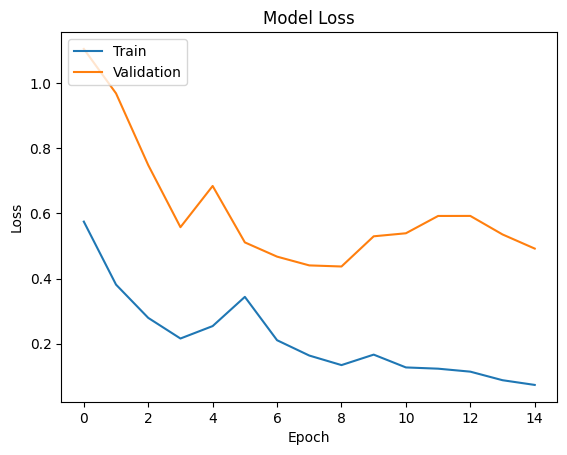

In [ ]:
plot_training_loss(model_with_BN)

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model

def convolutional_reduction():
  # define the input shape
  input_shape = (224, 224, 3)

  # define the input layer
  inputs = Input(shape=input_shape)

  # block 1
  x = Conv2D(64, (3, 3), activation="relu", padding='same', name='block1_conv1')(inputs)
  x = Conv2D(64, (3, 3), activation="relu", padding='same', name='block1_conv2')(x)
  x = MaxPooling2D(name='block1_pool')(x)

  # block 2
  x = Conv2D(32, (3, 3), activation="relu", padding='same', name='block2_conv2')(x)
  x = Conv2D(128, (3, 3), activation="relu", padding='same', name='block2_conv1')(x)
  x = MaxPooling2D(name='block2_pool')(x)

  # block 3
  x = Conv2D(64, (3, 3), activation="relu", padding='same', name='block3_conv2')(x)
  x = Conv2D(256, (3, 3), activation="relu", padding='same', name='block3_conv1')(x)
  x = MaxPooling2D(name='block3_pool')(x)

  # block 4
  x = Conv2D(256, (3, 3), activation="relu", padding='same', name='block4_conv3')(x)
  x = Conv2D(512, (3, 3), activation="relu", padding='same', name='block4_conv1')(x)
  x = Conv2D(512, (3, 3), activation="relu", padding='same', name='block4_conv2')(x)
  x = MaxPooling2D(name='block4_pool')(x)

  # block 5
  x = Conv2D(256, (3, 3), activation="relu", padding='same', name='block5_conv2')(x)
  x = Conv2D(512, (3, 3), activation="relu", padding='same', name='block5_conv1')(x)
  x = Conv2D(512, (3, 3), activation="relu", padding='same', name='block5_conv3')(x)
  x = MaxPooling2D(name='block5_pool')(x)

  # flatten the output and add a dense layer
  x = Flatten()(x)
  x = Dense(128, activation="relu", name='fc1')(x)
  x = Dense(2, activation='softmax', name='predictions')(x)

  # define the model
  model = Model(inputs, x)

  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
      metrics=["accuracy"]
  )

  return model



In [ ]:
def train_model_with_CR():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = convolutional_reduction()
  # Create early stopping callback
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                    patience=3)

  # Fit the model to the data
  model.fit(x=train_data,
            epochs=15,
            validation_data=val_data)
  
  return model

In [ ]:
# Fit the model to the data
model_with_CR = train_model_with_CR()

Epoch 1/15
100/100 [==============================] - 20s 110ms/step - loss: 0.6513 - accuracy: 0.6631 - val_loss: 0.4720 - val_accuracy: 0.7800
Epoch 2/15
100/100 [==============================] - 10s 98ms/step - loss: 0.4918 - accuracy: 0.7850 - val_loss: 0.5149 - val_accuracy: 0.7550
Epoch 3/15
100/100 [==============================] - 9s 94ms/step - loss: 0.4648 - accuracy: 0.7925 - val_loss: 0.4629 - val_accuracy: 0.7775
Epoch 4/15
100/100 [==============================] - 10s 99ms/step - loss: 0.4577 - accuracy: 0.7906 - val_loss: 0.4576 - val_accuracy: 0.8125
Epoch 5/15
100/100 [==============================] - 11s 111ms/step - loss: 0.4455 - accuracy: 0.8000 - val_loss: 0.4472 - val_accuracy: 0.7900
Epoch 6/15
100/100 [==============================] - 10s 94ms/step - loss: 0.4218 - accuracy: 0.8188 - val_loss: 0.4181 - val_accuracy: 0.8050
Epoch 7/15
100/100 [==============================] - 10s 99ms/step - loss: 0.4146 - accuracy: 0.8250 - val_loss: 0.4144 - val_accuracy

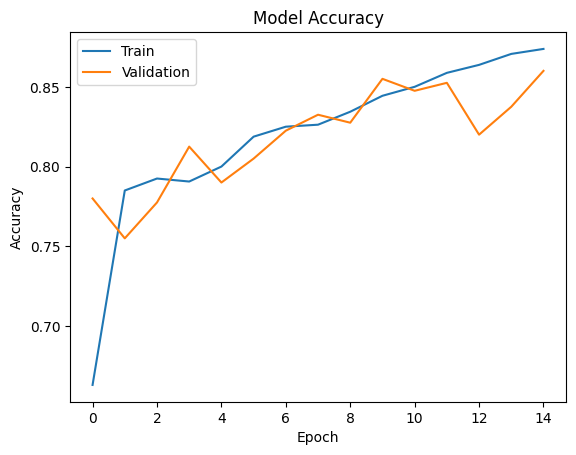

In [ ]:
plot_training_accuracy(model_with_CR)

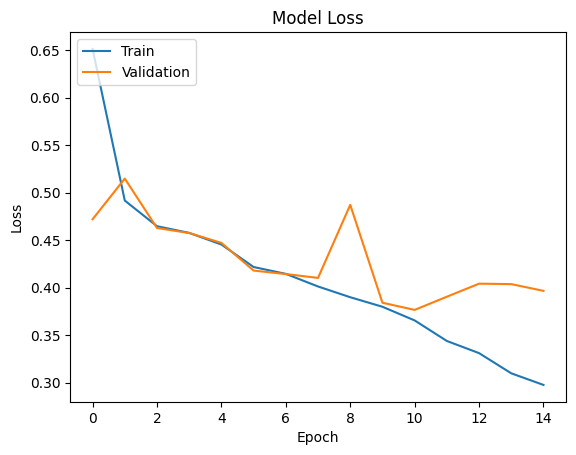

In [ ]:
plot_training_loss(model_with_CR)

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, MaxPooling2D, Flatten, Dense, DepthwiseConv2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16


def factored_convolutional():

  # Input layer
  input_layer = Input(shape=(224, 224, 3))

  # Conv block 1
  x = Conv2D(64, (1, 3), padding='same', activation=None)(input_layer)
  x = Conv2D(64, (3, 1), padding='same', activation=None)(x)
  x = MaxPooling2D((2, 2), strides=(2, 2))(x)

  # Conv block 2
  x = Conv2D(128, (1, 3), padding='same', activation=None)(x)
  x = Conv2D(128, (3, 1), padding='same', activation=None)(x)
  x = MaxPooling2D((2, 2), strides=(2, 2))(x)

  # Conv block 3
  x = Conv2D(256, (1, 3), padding='same', activation=None)(x)
  x = Conv2D(256, (3, 1), padding='same', activation=None)(x)
  x = Conv2D(256, (1, 3), padding='same', activation=None)(x)
  x = Conv2D(256, (3, 1), padding='same', activation=None)(x)
  x = MaxPooling2D((2, 2), strides=(2, 2))(x)

  # Conv block 4
  x = Conv2D(512, (1, 3), padding='same', activation=None)(x)
  x = Conv2D(512, (3, 1), padding='same', activation=None)(x)
  x = Conv2D(512, (1, 3), padding='same', activation=None)(x)
  x = Conv2D(512, (3, 1), padding='same', activation=None)(x)
  x = MaxPooling2D((2, 2), strides=(2, 2))(x)

  # Conv block 5
  x = Conv2D(512, (1, 3), padding='same', activation=None)(x)
  x = Conv2D(512, (3, 1), padding='same', activation=None)(x)
  x = Conv2D(512, (1, 3), padding='same', activation=None)(x)
  x = Conv2D(512, (3, 1), padding='same', activation=None)(x)
  x = MaxPooling2D((2, 2), strides=(2, 2))(x)

  # Flatten and dense layers
  x = Flatten()(x)
  x = Dense(64, activation=None)(x)
  x = Dense(32, activation=None)(x)
  output_layer = Dense(2, activation='softmax')(x)

  # Create the model
  model = Model(inputs=input_layer, outputs=output_layer)

  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
      metrics=["accuracy"]
  )

  return model

In [ ]:
def train_model_with_factored_convolutional():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = factored_convolutional()
  # Create early stopping callback
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                    patience=3)

  # Fit the model to the data
  model.fit(x=train_data,
            epochs=15,
            validation_data=val_data)
  
  return model

In [ ]:
model_factored_convolutional = train_model_with_factored_convolutional()

Epoch 1/15
100/100 [==============================] - 33s 264ms/step - loss: 0.5716 - accuracy: 0.7138 - val_loss: 0.4616 - val_accuracy: 0.7925
Epoch 2/15
100/100 [==============================] - 26s 257ms/step - loss: 0.4977 - accuracy: 0.7656 - val_loss: 0.4618 - val_accuracy: 0.7900
Epoch 3/15
100/100 [==============================] - 26s 260ms/step - loss: 0.4689 - accuracy: 0.7806 - val_loss: 0.4382 - val_accuracy: 0.8150
Epoch 4/15
100/100 [==============================] - 25s 252ms/step - loss: 0.4256 - accuracy: 0.8119 - val_loss: 0.5435 - val_accuracy: 0.7750
Epoch 5/15
100/100 [==============================] - 25s 252ms/step - loss: 0.3865 - accuracy: 0.8356 - val_loss: 0.4326 - val_accuracy: 0.8225
Epoch 6/15
100/100 [==============================] - 26s 262ms/step - loss: 0.3706 - accuracy: 0.8469 - val_loss: 0.4739 - val_accuracy: 0.8025
Epoch 7/15
100/100 [==============================] - 25s 251ms/step - loss: 0.3106 - accuracy: 0.8788 - val_loss: 0.5985 - val_ac

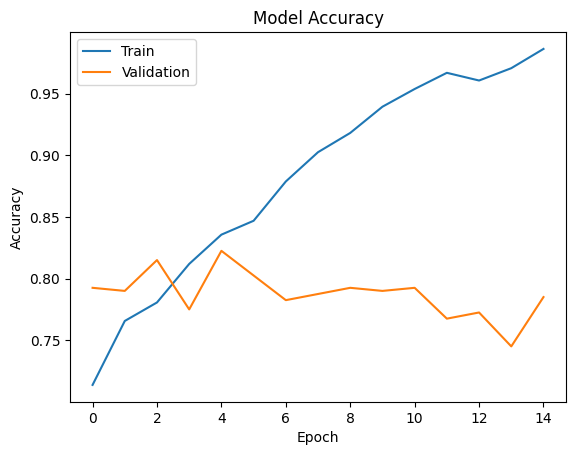

In [ ]:
plot_training_accuracy(model_factored_convolutional)

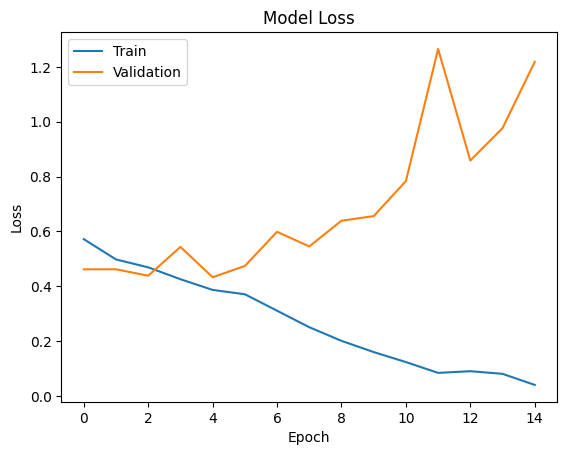

In [ ]:
plot_training_loss(model_factored_convolutional)

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, MaxPooling2D, Flatten, Dense, DepthwiseConv2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16


def vgg16_with_stride_2x2():
  # Input layer
  input_layer = Input(shape=(224, 224, 3))

  # Block 1
  x = Conv2D(64, (3, 3), padding='same', strides=(2,2), activation="relu")(input_layer)
  x = Conv2D(64, (3, 3), padding='same', activation="relu")(x)
  x = Conv2D(128, (3, 3), padding='same', activation="relu")(x)

  # Block 2
  x = Conv2D(128, (3, 3), strides=(2,2), padding='same', activation="relu")(x)
  x = Conv2D(128, (3, 3), padding='same', activation="relu")(x)
  x = Conv2D(128, (3, 3), padding='same', activation="relu")(x)

  # Block 3
  x = Conv2D(256, (3, 3), strides=(2,2), padding='same', activation="relu")(x)
  x = Conv2D(256, (3, 3), padding='same', activation="relu")(x)
  x = Conv2D(256, (3, 3), padding='same', activation="relu")(x)

  # Block 4
  x = Conv2D(512, (3, 3), strides=(2,2), padding='same', activation="relu")(x)
  x = Conv2D(512, (3, 3), padding='same', activation="relu")(x)
  x = Conv2D(512, (3, 3), padding='same', activation="relu")(x)

  # Block 5
  x = Conv2D(512, (3, 3), strides=(2,2), padding='same', activation="relu")(x)
  x = Conv2D(512, (3, 3), padding='same', activation="relu")(x)
  x = Conv2D(512, (3, 3), padding='same', activation="relu")(x)

  # Flatten and dense layers
  x = Flatten()(x)
  x = Dense(64, activation=None)(x)
  x = Dense(32, activation=None)(x)
  output_layer = Dense(2, activation='softmax')(x)

  # Create the model
  model = Model(inputs=input_layer, outputs=output_layer)

  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
      metrics=["accuracy"]
  )

  return model

In [ ]:
def train_model_with_stride_2x2():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = vgg16_with_stride_2x2()
  # Create early stopping callback
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                    patience=3)

  # Fit the model to the data
  model.fit(x=train_data,
            epochs=15,
            validation_data=val_data)
  
  return model

In [ ]:
model_stride_2x2 = train_model_with_stride_2x2()

Epoch 1/15
120/120 [==============================] - 902s 7s/step - loss: 0.6091 - accuracy: 0.6552 - val_loss: 0.5267 - val_accuracy: 0.7563
Epoch 2/15
120/120 [==============================] - 16s 130ms/step - loss: 0.5002 - accuracy: 0.7667 - val_loss: 0.5359 - val_accuracy: 0.7542
Epoch 3/15
120/120 [==============================] - 16s 131ms/step - loss: 0.4939 - accuracy: 0.7714 - val_loss: 0.5114 - val_accuracy: 0.7750
Epoch 4/15
120/120 [==============================] - 17s 145ms/step - loss: 0.4708 - accuracy: 0.7839 - val_loss: 0.5150 - val_accuracy: 0.7563
Epoch 5/15
120/120 [==============================] - 16s 137ms/step - loss: 0.4592 - accuracy: 0.7984 - val_loss: 0.4877 - val_accuracy: 0.7771
Epoch 6/15
120/120 [==============================] - 18s 153ms/step - loss: 0.4421 - accuracy: 0.8031 - val_loss: 0.5072 - val_accuracy: 0.7688
Epoch 7/15
120/120 [==============================] - 18s 146ms/step - loss: 0.4190 - accuracy: 0.8224 - val_loss: 0.5479 - val_accu

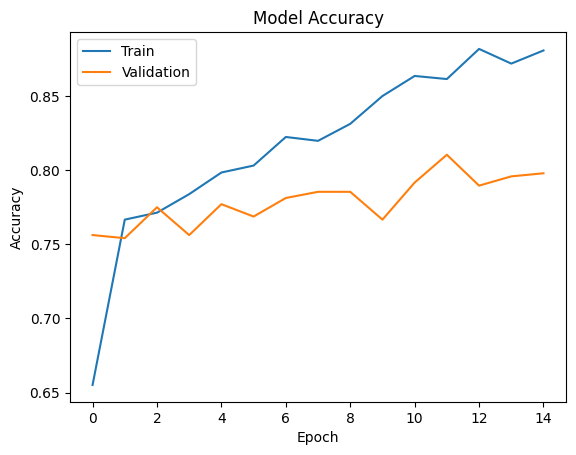

In [ ]:
plot_training_accuracy(model_stride_2x2)

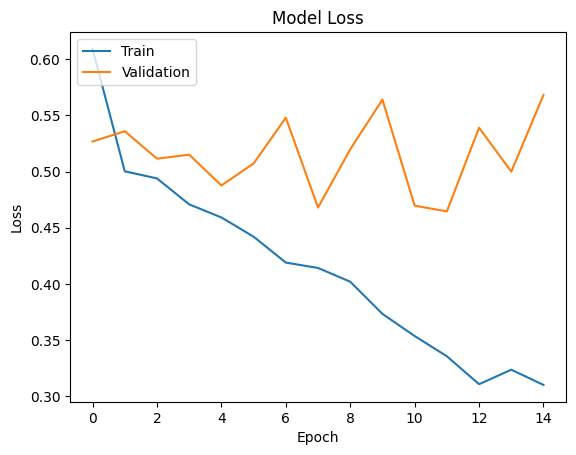

In [ ]:
plot_training_loss(model_stride_2x2)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Flatten, Dense, Add

def vgg16_with_skip_connections():
  # Define the input shape
  # Define the input shape
  input_shape = (224, 224, 3)

  # Load the VGG16 model without the top layers
  base_model = VGG16(weights=None, include_top=False, input_shape=input_shape)

  # Freeze the base model layers
  #for layer in base_model.layers:
      #layer.trainable = False

  # Add skip connections to the model
  skip1 = Conv2D(64, (1,1), activation='relu', padding='same')(base_model.output)
  skip2 = Conv2D(64, (1,1), activation='relu', padding='same')(skip1)
  x = Conv2D(64, (3,3), activation='relu', padding='same')(base_model.output)
  x = Add()([x, skip2])
  x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
  x = MaxPooling2D(pool_size=(2, 2))(x)
  x = Flatten()(x)
  x = Dense(256, activation='relu')(x)
  output = Dense(2, activation='softmax')(x)

  # Create the new model
  model = Model(inputs=base_model.input, outputs=output)

  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
      metrics=["accuracy"]
  )

  return model




In [ ]:
def train_model_with_skip_connections():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = vgg16_with_skip_connections()
  # Create early stopping callback
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                    patience=3)

  # Fit the model to the data
  model.fit(x=train_data,
            epochs=15,
            validation_data=val_data)
  
  return model

In [ ]:
model_skip_connections = train_model_with_skip_connections()

Epoch 1/15
120/120 [==============================] - 36s 243ms/step - loss: 0.6145 - accuracy: 0.6422 - val_loss: 0.5424 - val_accuracy: 0.7375
Epoch 2/15
120/120 [==============================] - 29s 244ms/step - loss: 0.5253 - accuracy: 0.7641 - val_loss: 0.5916 - val_accuracy: 0.6875
Epoch 3/15
120/120 [==============================] - 28s 235ms/step - loss: 0.4909 - accuracy: 0.7755 - val_loss: 0.5160 - val_accuracy: 0.7542
Epoch 4/15
120/120 [==============================] - 29s 241ms/step - loss: 0.4801 - accuracy: 0.7932 - val_loss: 0.5216 - val_accuracy: 0.7792
Epoch 5/15
120/120 [==============================] - 29s 242ms/step - loss: 0.4754 - accuracy: 0.7849 - val_loss: 0.5515 - val_accuracy: 0.7208
Epoch 6/15
120/120 [==============================] - 29s 241ms/step - loss: 0.4648 - accuracy: 0.7932 - val_loss: 0.5008 - val_accuracy: 0.7667
Epoch 7/15
120/120 [==============================] - 29s 243ms/step - loss: 0.4484 - accuracy: 0.8047 - val_loss: 0.4949 - val_ac

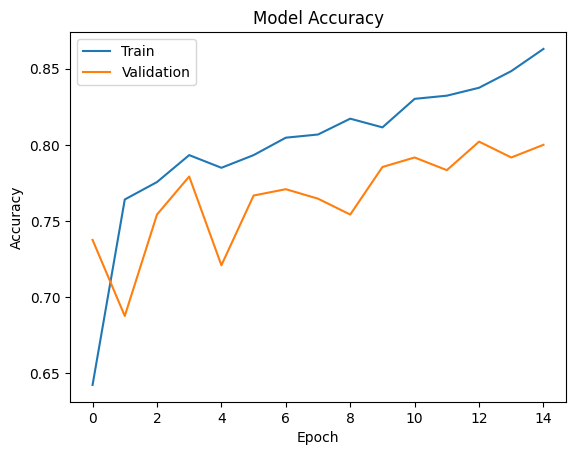

In [ ]:
plot_training_accuracy(model_skip_connections)

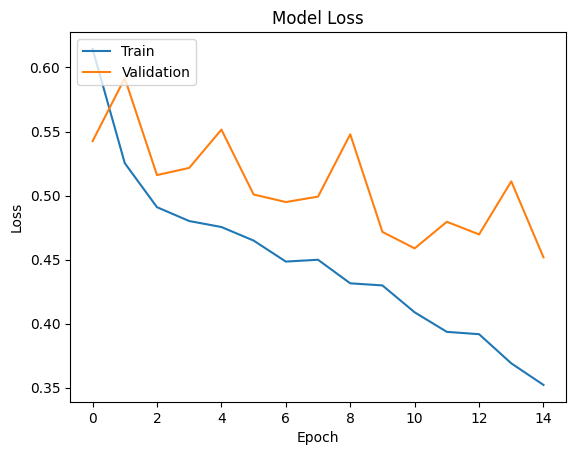

In [ ]:
plot_training_loss(model_skip_connections)